# Arbitrary Style Transfer with Adaptive Instance Normalization

dated: 3 Feb 2023

Paolo Zinesi

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import random

from tqdm import tqdm, trange

In [2]:
torch.manual_seed(17)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# I/O -----------------------------

#STYLE_IMAGE_FILE = "./image/starry_night.jpg"
#STYLE_IMAGE_FILE = "./image/picasso.jpg"
#STYLE_IMAGE_FILE = "./image/the_scream.jpg"

#CONTENT_IMAGE_FILE = "./image/tuebingen.jpg"
#CONTENT_IMAGE_FILE = "./image/golden_gate.jpg"
#CONTENT_IMAGE_FILE = "./image/dancing.jpg"

## Model definition

In [4]:
class AdaIN(nn.Module):
    """ Implementation of Adaptive Instance Normalization (AdaIN) layer as described in the paper."""

    def __init__(self, eps=1e-5):
        super().__init__()

        self.eps = eps
    

    def forward(self, x, y):
        """ Inputs:
                - x: content input of size (N,C,H,W) or (C,H,W)
                - y: style input of size (N,C,H,W) or (C,H,W)
            Output:
                - AdaIN_x_y: scaled content such that it matches channel-wise mean and variances of the style
        """

        # transform x to a 4-dim tensor
        if x.dim() == 3:
            content = torch.unsqueeze(x.detach(), 0)
        elif x.dim() == 4:
            content = x.detach()
        else:
            content = None

        # transform y to a 4-dim tensor
        if y.dim() == 3:
            style = torch.unsqueeze(y.detach(), 0)
        elif y.dim() == 4:
            style = y.detach()
        else:
            style = None
        
        # means and stds with sizes = (N,C,1,1)
        style_mean = torch.mean(style, dim=[2,3], keepdim=True)
        style_std = torch.std(style, dim=[2,3], keepdim=True) + self.eps
        content_mean = torch.mean(content, dim=[2,3], keepdim=True)
        content_std = torch.std(content, dim=[2,3], keepdim=True) + self.eps

        # result
        AdaIN_x_y = style_std * ((content - content_mean)/content_std) + style_mean

        return AdaIN_x_y

In [5]:
class VGG_Encoder_network(nn.Module):
    """ Network that encodes on the first layers of a VGG-19 network the content and the style of images.
        This network is shallower than the original VGG-19.
        This implementation is ALMOST identical to the network used for NST (of Gatys)."""

    def __init__(self, input_model, forward_hooks:list,
                 pool:str = 'max',  crop_model:bool = True
                ):
        super().__init__()

        # -----------------------------
        #       HOOKS MANAGEMENT
        # -----------------------------
        self.hooks, self.hook_handlers = {}, []
        def takeOutput(name:str):
            def hook(model, input, output):
                self.hooks[name] = output.clone().detach()
                # note: DETACH! Gradients are not needed on the encoder network
                #       feature maps because only the feature maps of the decoder
                #       appear in the loss functions
            return hook
        #
        #  self.hook_handlers     will store the handlers of
        #                         fwd hooks I will register
        #  self.hooks             will store the values taken with hooks
        #                         from selected layers

        self.hooks_init = forward_hooks.copy()  # keep a backup copy of this arg
        todo_hooks = set(forward_hooks)         # will use this list while I loop on network layers


        # --------------------------------------
        #              MODEL BUILD
        # --------------------------------------
        #   Loop over the input model layers,
        #   registering a hook when requested.
        #   Only the layers until a hook is
        #   needed are kept.
        # --------------------------------------
        self.model = nn.Sequential()
        self.required_factor = 1 # useful to match the encoder with the decoder
        

        conv_num, conv_group = 1, 1
        for layer in input_model.children():
            
            if isinstance(layer, nn.Conv2d):
                name = 'conv{}_{}'.format(conv_group, conv_num)
            
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(conv_group, conv_num)
                #  ^^  takes the name similar to last conv layer
                conv_num += 1

            elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d) ):
                # take name & reset counters
                name = 'pool_{}'.format(conv_group)
                conv_group += 1;   conv_num = 1; 

                # update required factorization every time a pooling
                # layer is present
                self.required_factor *= layer.stride

                # replace pool layer with desired choice
                if   pool.lower() == 'avg':
                    layer = nn.AvgPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                elif pool.lower() == 'max':
                    layer = nn.MaxPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                else:
                    raise RuntimeError('not valid pool arg ({})'.format(pool))

            else: name = 'buh'
            
            self.model.add_module(name, layer)
        

            if name in todo_hooks:
                # register a hook for current layer and track its handler
                # remember: NO gradient here is computed!
                self.hook_handlers.append(
                    self.model[-1].register_forward_hook( takeOutput(name) )
                )
                todo_hooks.remove(name)

            # useful to remove layers 
            if crop_model:
                if not todo_hooks: break
                
        
        # fix the weights, to be sure
        for param in self.model.parameters():
            param.requires_grad = False

        # set to eval mode
        self.model.eval()


    def forward(self, x, query : list = None):
        
        # to maintain the same shape in the encoder-decoder
        # architecture, a shape multiple of self.required_factor is enforced
        if np.any(np.array(x.shape[-2:]) % self.required_factor != 0):
            raise RuntimeError(f"The spatial shapes must be multiple of {self.required_factor}, but they are {list(x.shape[-2:])}")

        self.hooks = {}     # reset hooks dict

        # This passage computes both the result of the encoded x and the 
        # activations of any layer. The gradient is only propagated in the 
        # forward pass, but no gradient of the feature maps is computed.
        encoded_x = self.model(x)

        # returns the encoded features and the features extracted by hooks
        if query is not None:
            return (encoded_x, [ self.hooks[key] for key in query ])
            # this is a (torch.Tensor, list)
        else:
            return (encoded_x, self.hooks)
            # this is a (torch.Tensor, dict)

In [6]:
class Decoder_network(nn.Module):
    """ Network that decodes the AdaIN result 't' into the synthetized image 'g(t)'.
        This network has an architecture that is the mirrored version of the encoder, 
        it is shallower than the VGG-19 architecture and it needs to be trained.
    """

    def __init__(self, input_model, last_layer:str, forward_hooks:list,
                 pool:str = 'max'
                ):
        super().__init__()

        # -----------------------------
        #       HOOKS MANAGEMENT
        # -----------------------------
        self.hooks, self.hook_handlers = {}, []
        def takeOutput(name:str):
            def hook(model, input, output):
                self.hooks[name] = output.clone()
                # note: DO NOT DETACH! Gradients of the decoder feature maps
                #       are needed in the style loss.
            return hook
        #
        #  self.hook_handlers     will store the handlers of
        #                         fwd hooks I will register
        #  self.hooks             will store the values taken with hooks
        #                         from selected layers

        self.hooks_init = forward_hooks.copy()  # keep a backup copy of this arg
        todo_hooks = set(forward_hooks)         # will use this list while I loop on network layers


        # --------------------------------------
        #              MODEL BUILD
        # --------------------------------------
        #   Loop over the input model layers, 
        #   registering the layers of the original 
        #   model to be inverted. Then, the original 
        #   layers are mapped into the decoder layers 
        #   (in reversed order) and finally the decoder 
        #   model is built from the list of reversed layers.
        # --------------------------------------
        self.model = nn.Sequential()
        self.original_layers = []
        self.reversed_layers = []
        
        #
        # loop and save all the original layers
        #
        conv_num, conv_group = 1, 1
        for layer in input_model.children():
            
            if isinstance(layer, nn.Conv2d):
                name = 'conv{}_{}'.format(conv_group, conv_num)
            
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(conv_group, conv_num)
                #  ^^  takes the name similar to last conv layer
                conv_num += 1

            elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d) ):
                # take name & reset counters
                name = 'pool_{}'.format(conv_group)
                conv_group += 1;   conv_num = 1; 

                # replace pool layer with desired choice
                if   pool.lower() == 'avg':
                    layer = nn.AvgPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                elif pool.lower() == 'max':
                    layer = nn.MaxPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                else:
                    raise RuntimeError('not valid pool arg ({})'.format(pool))

            else: name = 'buh'
            
            # add to the list to revert
            self.original_layers.append((name, layer))

            # when the final layer is reached, stop the inclusion of new layers
            if name == last_layer:
                break


        #
        # loop to map the original layers into the decoder layers (in reversed order)
        #
        in_ch, out_ch = -1, -1
        for orig_name, orig_layer in self.original_layers:
            
            if "conv" in orig_name:
                # used to initialize the corresponding ConvTranspose2d module
                in_ch = orig_layer.out_channels
                out_ch = orig_layer.in_channels

                self.reversed_layers.append((orig_name.replace("conv", "relu"), nn.ReLU()))

            elif "relu" in orig_name:
                self.reversed_layers.append((orig_name.replace("relu", "conv"), nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=1, padding=2)))
                self.reversed_layers.append((orig_name.replace("relu", "reflpad"), nn.ReflectionPad2d(1)))
                
            elif "pool" in orig_name:
                self.reversed_layers.append((orig_name.replace("pool", "upscale"), nn.Upsample(scale_factor=2)))
            else:
                None
            
        #
        # loop to build the correct decoder model
        #
        for rev_name, rev_layer in reversed(self.reversed_layers):
            
            self.model.add_module(rev_name, rev_layer)

            if rev_name in todo_hooks:
                # register a hook for current layer and track its handler
                # The gradient here is propagated
                self.hook_handlers.append(
                    self.model[-1].register_forward_hook( takeOutput(rev_name) )
                )
                todo_hooks.remove(rev_name)




    def forward(self, x, query : list = None):

        self.hooks = {}     # reset hooks dict

        # This passage computes both the result of the encoded x and the 
        # activations of any layer. The gradient is propagated both in the 
        # forward pass and in the feature maps.
        decoded_x = self.model(x)

        # returns the features extracted by hooks
        if query is not None:
            return (decoded_x, [ self.hooks[key] for key in query ])
            # this is a (torch.Tensor, list)
        else:
            return (decoded_x, self.hooks)
            # this is a (torch.Tensor, dict)

## Image processing

In [7]:
class CropToMultiple(nn.Module):
    """ Custom crop transformation to a multiple of a given number.

    Args:
        factor (tuple or int): Desired factor of transformed type.
    """

    def __init__(self, factor):
        super().__init__()
        assert isinstance(factor, (int, tuple))
        if isinstance(factor, int):
            self.factor = (factor, factor)
        else:
            assert len(factor) == 2
            self.factor = factor

    def forward(self, img):

        w, h = img.size[-2:]
        new_h = self.factor[0] * (h // self.factor[0])
        new_w = self.factor[1] * (w // self.factor[1])

        return transforms.CenterCrop((new_h, new_w))(img)

In [8]:
# take the original VGG-19 model (pretrained weights)
vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')

# according to VGG199 documentation, the network uses these
# parameters for input normalization
vgg19_mean = np.array( [0.485, 0.456, 0.406] )
vgg19_std = np.array( [0.229, 0.224, 0.225] )



# pre and post processing for images
img_size = 256
factor = 8 #VGG_Encoder.required_factor 

img_preprocess = transforms.Compose([
        transforms.Resize(img_size),
        CropToMultiple(factor), # enforce factorizability of the image shapes
        transforms.ToTensor(),
        transforms.Normalize(mean = vgg19_mean, std=vgg19_std),
        transforms.Lambda(lambda x: x.mul_(255)),
])

img_revert = transforms.Compose([
        transforms.Lambda(lambda x: x.mul_(1./255)),
        transforms.Normalize(mean = [ 0., 0., 0. ], std = 1/vgg19_std),
        transforms.Normalize(mean = -vgg19_mean, std = [1,1,1]),
])

transf_toPIL = transforms.Compose([ transforms.ToPILImage() ])

def tens2pil( img_tensor ):
    img_tensor = img_tensor.clone().detach()
    # invert the input trasform
    x = img_revert(img_tensor)
    # removed burned areas
    t = torch.clamp( x, min=0, max=1)
    return transf_toPIL( torch.squeeze(t) )

In [9]:
def load_image(filename, preprocess = None, device = None, add_batch : bool = True):
    img = Image.open(filename)

    # optional: apply custom preprocess function, else use the default
    if preprocess: img = preprocess(img)
    else:          img = img_preprocess(img)

    # optional: send to device
    if device:     img = img.to(device)

    # optional: add dummy batch dimention
    if add_batch:  img = img.unsqueeze(0)
    
    return img

# Import of datasets

### Art dataset

Download this https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder.tar

In [26]:
art_foldername = "image/artbench-10/"
content_foldername = "image/content_dataset/"

In [27]:
def check_Image(path):
  """ Function to check if an image is corrupted or not.
  """
  
  try:
    im = Image.open(path)
    return True
  except:
    return False

In [28]:
# create dataset by loading only non-corrupted images
art_dataset = ImageFolder(art_foldername, is_valid_file=check_Image, transform=img_preprocess)
art_loader = DataLoader(art_dataset, batch_size = 8, shuffle = True)

### Content dataset

In [31]:
content_dataset = datasets.Places365(content_foldername, transform=img_preprocess,  small=True, split="val") #download=True
content_loader = DataLoader(content_dataset, batch_size = 8, shuffle = True)

## Network allocation

To do this I need the list of layer to hook from.

**Important convention**: The names of the decoder layers reflects the names of the corresponding original layer from which they derive. For instance, a `conv1_2` layer is mapped into a `conv1_2` layer in the decoder. However, the names of the feature maps correspond to the layer of which we are observing the output. For these reasons, the feature maps with the same shapes have names shifted by 1 (e.g., `relu1_1` and `relu1_2`). This weird convention is used to keep the same convention in the naming of the feature maps across the encoder-decoder architecture.

In [54]:
content_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1']
style_layers = ['relu1_2', 'relu2_2', 'relu3_2', 'relu4_2']

**Ref**: VGG19 doc
https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html

> Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.

In [55]:
# create models
AdaIN_layer = AdaIN()
AdaIN_layer.to(device)

VGG_Encoder = VGG_Encoder_network(vgg19.features, content_layers)
VGG_Encoder.to(device)

Decoder = Decoder_network(vgg19.features, "relu4_2", style_layers)
Decoder.to(device); 

# Training

In [56]:
iter_max = 1000
lr = 1e-4
content_importance = 10.0
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(Decoder.parameters(), lr=lr)

In [57]:
# run style transfer
Decoder.train()
losses_style, losses_content = [], []
for i in trange(iter_max):

    # retrieve images
    content_image_batch, _ = next(iter(content_loader))
    content_image_batch = content_image_batch.to(device)
    style_image_batch, _ = next(iter(art_loader))
    style_image_batch = style_image_batch.to(device)

    # ---------------------------------
    # No gradient is required here
    # ---------------------------------
    with torch.no_grad():

        # compute features of images (= f(c) and f(s))
        enc_image, hooks_enc_image = VGG_Encoder(content_image_batch)
        enc_style, hooks_enc_style = VGG_Encoder(style_image_batch)

        # compute target feature map (= t)
        target_feat_map = AdaIN_layer(enc_image, enc_style)



    # ---------------------------------
    # Gradients are now required
    # ---------------------------------
    optimizer.zero_grad()


    # generate stylized image (= g(t))
    generated_img, hooks_generated_img = Decoder(target_feat_map)

    # features of the stylized image (=f(g(t)))
    enc_generated_img, hooks_enc_generated_img = VGG_Encoder(generated_img)


    # LOSSES
    loss_style = 0
    for layer_s, layer_c in zip(style_layers, content_layers):
        # retrieve feature maps
        layer_generated_img = hooks_generated_img[layer_s]
        layer_enc_style = hooks_enc_style[layer_c]

        # compute (mu, std) for style loss
        mu_generated_img = torch.mean(layer_generated_img, dim=[2,3], keepdim=True)
        std_generated_img = torch.std(layer_generated_img, dim=[2,3], keepdim=True)
        mu_enc_style = torch.mean(layer_enc_style, dim=[2,3], keepdim=True)
        std_enc_style = torch.std(layer_enc_style, dim=[2,3], keepdim=True)

        # style loss between g(t) and s
        loss_style = loss_style + loss_fn(mu_generated_img, mu_enc_style) + loss_fn(std_generated_img, std_enc_style)

    # content loss between f(g(t)) and t
    loss_cont = loss_fn(enc_generated_img, target_feat_map)

    # keep track
    losses_style.append(loss_style.detach().cpu().numpy())
    losses_content.append(loss_cont.detach().cpu().numpy())

    # sum the two losses
    loss = loss_style + content_importance*loss_cont

    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]


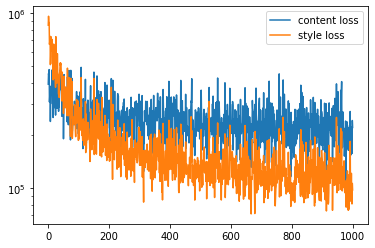

In [58]:
plt.plot(losses_content, label="content loss")
plt.plot(losses_style, label="style loss")
plt.yscale("log")
plt.legend()

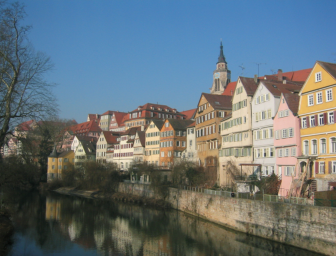

In [64]:
content_image = load_image("./image/tuebingen.jpg", device = device)
tens2pil(content_image)

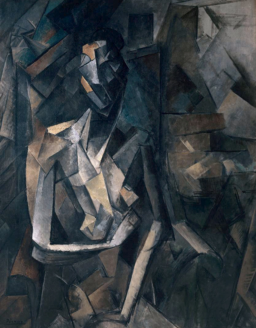

In [67]:
style_image = load_image("./image/picasso.jpg", device = device)
tens2pil(style_image)

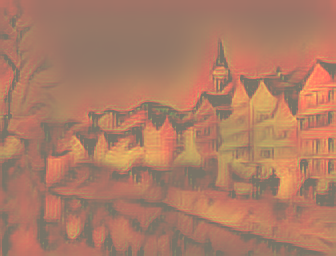

In [68]:
Decoder.eval()

f_c, _ = VGG_Encoder(content_image)
f_s, _ = VGG_Encoder(style_image)
t_ = AdaIN_layer(f_c, f_s)
T_c_s, _ = Decoder(t_)

tens2pil(T_c_s)